In [787]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout,GRU
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from tensorflow.keras import optimizers, Model
import matplotlib.pyplot as plt
import math

# Load Data

In [788]:
import os
CURR_FOLDER_PATH = os.getcwd()
BASE_PATH = os.path.dirname(os.path.dirname(CURR_FOLDER_PATH))
DATA_PATH = os.path.join(BASE_PATH, 'Lulus/data')

In [789]:
df = pd.read_excel(DATA_PATH + '/Hargalagpasartradisionallagvariable.xlsx')
# Data yang digunakan yaitu Harga cabai Rawit dan Harga Bawang putih sebagai Barang Subtitusi Sudah dilakukan lag - 1 Minggu

In [790]:
df

,Tanggal,Harga Cabai Merah,Harga Cabai Rawit
0,01/ 01/ 2018,-,-
1,08/ 01/ 2018,38300,-
2,15/ 01/ 2018,42800,42600
3,22/ 01/ 2018,37850,42700
4,29/ 01/ 2018,38950,42600
...,...,...,...
308,27/ 11/ 2023,80250,76600
309,04/ 12/ 2023,94900,79150
310,11/ 12/ 2023,99300,79100
311,18/ 12/ 2023,85000,75550


# Statistical Analytics

In [791]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Tanggal            313 non-null    object
 1   Harga Cabai Merah  313 non-null    object
 2   Harga Cabai Rawit  313 non-null    object
dtypes: object(3)
memory usage: 7.5+ KB


In [792]:
df.shape

(313, 3)

In [793]:
df.replace('-', pd.NA, inplace=True)

In [794]:
missing_values = df.isnull().sum()
percentage_missing = (missing_values / df.shape[0]) * 100
print("Jumlah Missing Value per Kolom:")
print(missing_values)
print("\nPersentase Missing Value per Kolom:")
percentage_missing

Jumlah Missing Value per Kolom:
Tanggal              0
Harga Cabai Merah    9
Harga Cabai Rawit    9
dtype: int64

Persentase Missing Value per Kolom:


Tanggal              0.000000
Harga Cabai Merah    2.875399
Harga Cabai Rawit    2.875399
dtype: float64

In [795]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/ %m/ %Y')
df['Bulan'] = df['Tanggal'].dt.to_period('M')
mean_values = df.groupby('Bulan').mean()


def fill_missing_with_mean(row):
    if pd.isna(row['Harga Cabai Merah']):
        row['Harga Cabai Merah'] = mean_values.loc[row['Bulan'], 'Harga Cabai Merah']
    if pd.isna(row['Harga Cabai Rawit']):
        row['Harga Cabai Rawit'] = mean_values.loc[row['Bulan'], 'Harga Cabai Rawit']
    return row


df = df.apply(fill_missing_with_mean, axis=1)
print(df)

       Tanggal  Harga Cabai Merah  Harga Cabai Rawit    Bulan
0   2018-01-01       39475.000000       42633.333333  2018-01
1   2018-01-08       38300.000000       42633.333333  2018-01
2   2018-01-15       42800.000000       42600.000000  2018-01
3   2018-01-22       37850.000000       42700.000000  2018-01
4   2018-01-29       38950.000000       42600.000000  2018-01
..         ...                ...                ...      ...
308 2023-11-27       80250.000000       76600.000000  2023-11
309 2023-12-04       94900.000000       79150.000000  2023-12
310 2023-12-11       99300.000000       79100.000000  2023-12
311 2023-12-18       85000.000000       75550.000000  2023-12
312 2023-12-25       93066.666667       66350.000000  2023-12

[313 rows x 4 columns]


In [796]:
df['Harga Cabai Merah'] = df['Harga Cabai Merah'].astype('float64')
df['Harga Cabai Rawit'] = df['Harga Cabai Rawit'].astype('float64')

In [797]:
import seaborn as sns

harga_merah_stats = df['Harga Cabai Merah'].describe()
print("\nStatistik Deskriptif Harga Cabai Merah:")
print(harga_merah_stats)


harga_rawit_stats = df['Harga Cabai Rawit'].describe()
print("\nStatistik Deskriptif Harga Cabai Rawit:")
print(harga_rawit_stats)



Statistik Deskriptif Harga Cabai Merah:
count       313.000000
mean      43092.092652
std       15493.651894
min       21750.000000
25%       31650.000000
50%       40800.000000
75%       49550.000000
max      109450.000000
Name: Harga Cabai Merah, dtype: float64

Statistik Deskriptif Harga Cabai Rawit:
count       313.000000
mean      44877.715655
std       17241.023349
min       22600.000000
25%       30950.000000
50%       42000.000000
75%       54250.000000
max      100750.000000
Name: Harga Cabai Rawit, dtype: float64


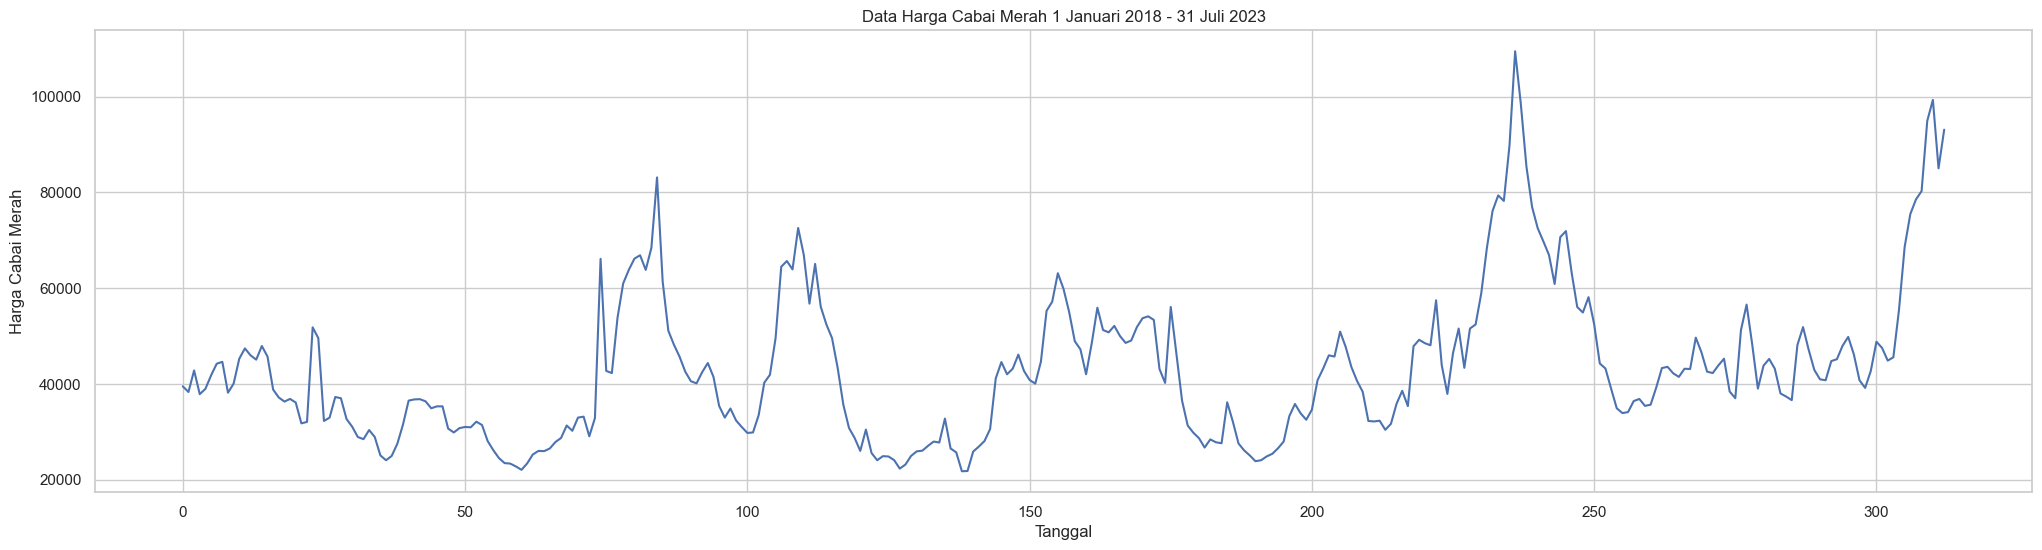

In [798]:
# Visualisasi
plt.figure(figsize=(25, 6))
plt.plot(df.index, df['Harga Cabai Merah'])
plt.title('Data Harga Cabai Merah 1 Januari 2018 - 31 Juli 2023')
plt.xlabel('Tanggal')
plt.ylabel('Harga Cabai Merah')
plt.show()

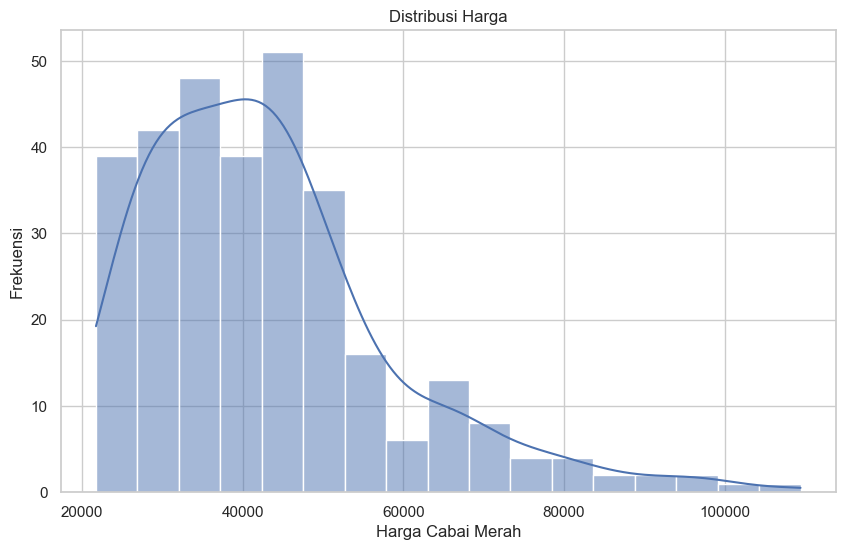

In [799]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Harga Cabai Merah'], kde=True)
plt.title('Distribusi Harga')
plt.xlabel('Harga Cabai Merah')
plt.ylabel('Frekuensi')
plt.show()

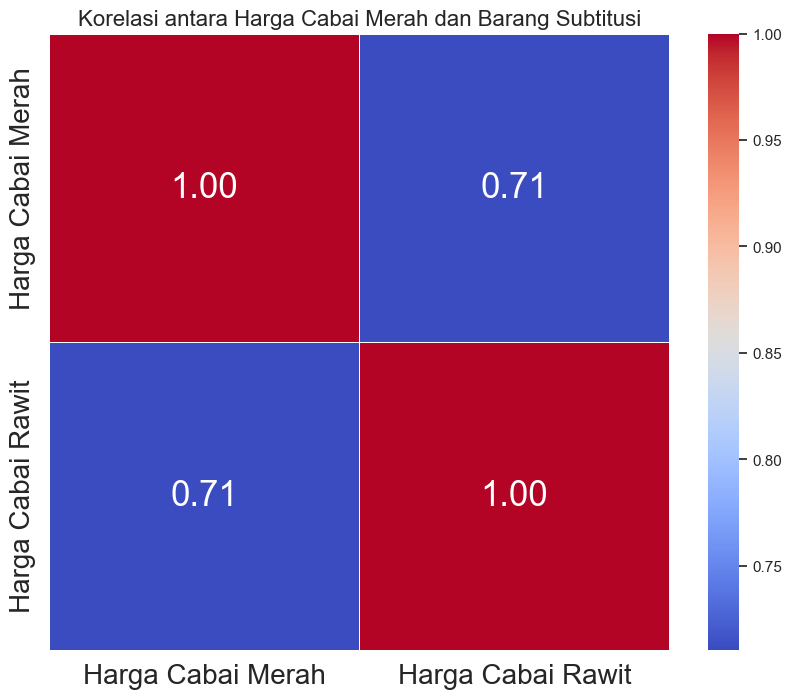

In [800]:
corr_with_target = df[['Harga Cabai Merah','Harga Cabai Rawit']].corr()
# Membuat heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5,
                      annot_kws={"size": 25})  # Ukuran font diperbesar menjadi 25

# Memperbesar ukuran font label pada sumbu x dan y
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)

# Menambahkan judul
plt.title('Korelasi antara Harga Cabai Merah dan Barang Subtitusi', fontsize=16)

# Menampilkan heatmap
plt.show()

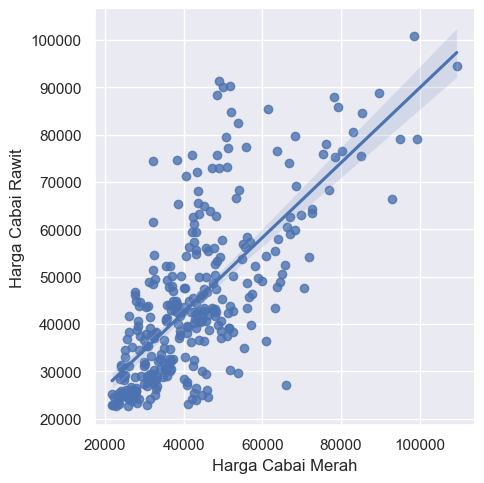

In [801]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
df.head()
sns.lmplot(x="Harga Cabai Merah", y="Harga Cabai Rawit", data=df)
plt.show()

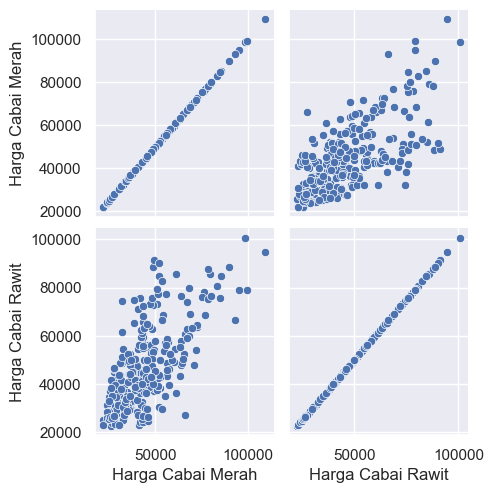

In [802]:
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.pairplot(df, diag_kind=None)
plt.show()

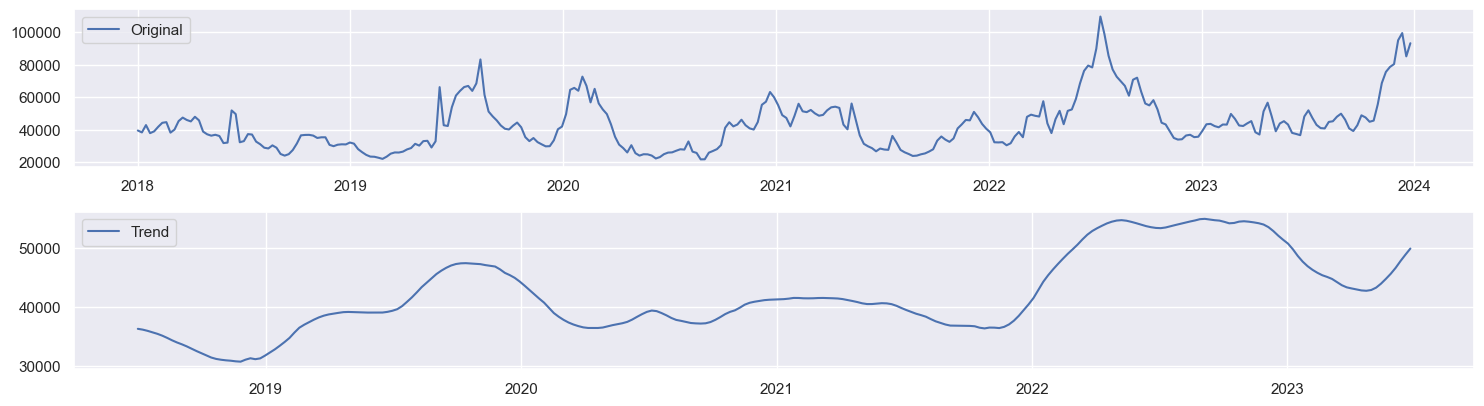

In [803]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ubah kolom 'Tanggal' menjadi tipe datetime dan tetapkan sebagai indeks
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
df.set_index('Tanggal', inplace=True)

# Melakukan dekomposisi musiman
decomposition = seasonal_decompose(df['Harga Cabai Merah'], model='additive')

# Menampilkan hasil
plt.figure(figsize=(15, 8))

# Data asli
plt.subplot(411)
plt.plot(df.index, df['Harga Cabai Merah'], label='Original')
plt.legend(loc='upper left')

# Trend
plt.subplot(412)
plt.plot(decomposition.trend.index, decomposition.trend, label='Trend')
plt.legend(loc='upper left')


plt.tight_layout()
plt.show()


# Preprocessing Data


In [804]:
scaler_rr = MinMaxScaler(feature_range=(0, 1))
scaler_harga = MinMaxScaler(feature_range=(0, 1))
df['Harga Cabai Merah_Scaled'] = scaler_harga.fit_transform(df[['Harga Cabai Merah']])
df['Harga Cabai Rawit_Scaled'] = scaler_rr.fit_transform(df[['Harga Cabai Rawit']])

In [805]:
df.head()

,Harga Cabai Merah,Harga Cabai Rawit,Bulan,Harga Cabai Merah_Scaled,Harga Cabai Rawit_Scaled
Tanggal,,,,,
2018-01-01,39475.0,42633.333333,2018-01,0.202109,0.256345
2018-01-08,38300.0,42633.333333,2018-01,0.188712,0.256345
2018-01-15,42800.0,42600.000000,2018-01,0.240023,0.255918
2018-01-22,37850.0,42700.000000,2018-01,0.183580,0.257198
2018-01-29,38950.0,42600.000000,2018-01,0.196123,0.255918


# Split Data

In [806]:
selected_columns = ['Harga Cabai Merah_Scaled','Harga Cabai Rawit_Scaled']
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)][selected_columns].values
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back + 1]['Harga Cabai Merah_Scaled'].values)
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], len(selected_columns)))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], len(selected_columns)))

# Pembuatan Model

In [807]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# List parameter yang akan diuji
units_list = [10, 30, 50, 70, 90, 110, 130, 150, 170, 200, 250, 300]
epochs_list = [50, 70, 90, 110, 130, 150, 170, 200]
batch_size_list = [8, 16, 32, 64, 128, 256, 512]

# Loop untuk mencoba semua kombinasi parameter
for units in units_list:
    for epochs in epochs_list:
        for batch_size in batch_size_list:
            # Membuat model
            model = Sequential()
            model.add(LSTM(units=units, return_sequences=True, input_shape=(look_back, 2), activation='relu'))
            model.add(LSTM(units=units, activation='relu'))
            model.add(Dense(units=1, activation='linear'))
            model.compile(optimizer='adam', loss='mean_squared_error')
            # Melatih model
            history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2)
            # Mendapatkan validation loss
            val_loss = np.min(history.history['val_loss'])
            # Mencetak hasil
            print(f"Units: {units}, Epochs: {epochs}, Batch Size: {batch_size}, Validation Loss: {val_loss}")


Units: 10, Epochs: 50, Batch Size: 8, Validation Loss: 0.005967052187770605
Units: 10, Epochs: 50, Batch Size: 16, Validation Loss: 0.007698005065321922
Units: 10, Epochs: 50, Batch Size: 32, Validation Loss: 0.018923403695225716
Units: 10, Epochs: 50, Batch Size: 64, Validation Loss: 0.06436030566692352
Units: 10, Epochs: 50, Batch Size: 128, Validation Loss: 0.10313016176223755
Units: 10, Epochs: 50, Batch Size: 256, Validation Loss: 0.1484147310256958
Units: 10, Epochs: 50, Batch Size: 512, Validation Loss: 0.1187310591340065
Units: 10, Epochs: 70, Batch Size: 8, Validation Loss: 0.010279892943799496
Units: 10, Epochs: 70, Batch Size: 16, Validation Loss: 0.011277271434664726
Units: 10, Epochs: 70, Batch Size: 32, Validation Loss: 0.01206345297396183
Units: 10, Epochs: 70, Batch Size: 64, Validation Loss: 0.02866421639919281
Units: 10, Epochs: 70, Batch Size: 128, Validation Loss: 0.04265904426574707
Units: 10, Epochs: 70, Batch Size: 256, Validation Loss: 0.10780004411935806
Units:

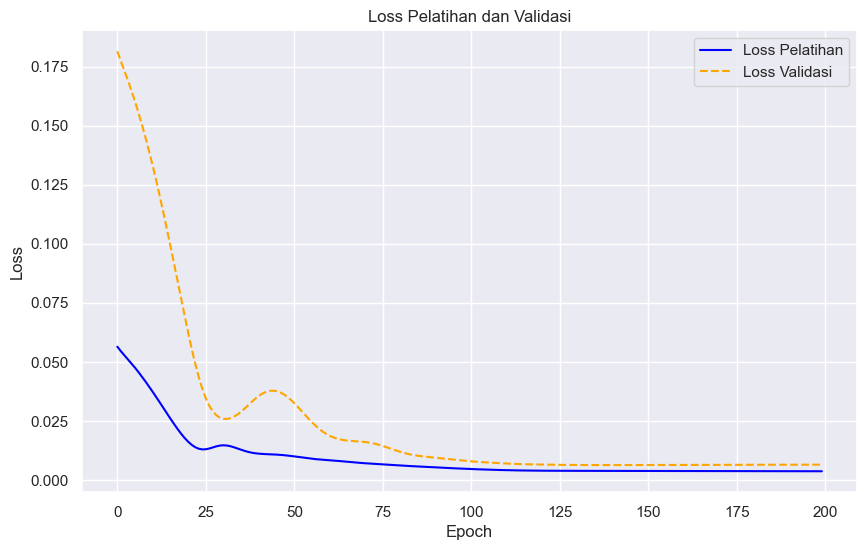

In [808]:
import matplotlib.pyplot as plt
import numpy as np

# Misalkan 'history' adalah objek yang didapatkan setelah melatih model
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')  # Jika validasi split digunakan

# Ubah list menjadi array NumPy
train_loss_np = np.array(train_loss)
val_loss_np = np.array(val_loss) if val_loss else None

# Siapkan plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot loss pelatihan
ax.plot(train_loss_np, label='Loss Pelatihan', linestyle='-', color='blue')

# Plot loss validasi (jika tersedia)
if val_loss_np is not None:
    ax.plot(val_loss_np, label='Loss Validasi', linestyle='--', color='orange')

# Label dan judul
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss Pelatihan dan Validasi')

# Legenda
ax.legend()

# Grid (opsional)
ax.grid(True)

# Tampilkan atau simpan plot
plt.show()  # atau plt.savefig('loss_curve.png')

#の説明 ada di komentar di bawah kode


In [809]:
model.summary()

Model: "sequential_1472"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2944 (LSTM)            (None, 1, 300)            363600    
                                                                 
 lstm_2945 (LSTM)            (None, 300)               721200    
                                                                 
 dense_1472 (Dense)          (None, 1)                 301       
                                                                 
Total params: 1,085,101
Trainable params: 1,085,101
Non-trainable params: 0
_________________________________________________________________


In [810]:
import tensorflow as tf

# Simpan model dalam format .h5
#model.save("modelbener.h5")

# Muat kembali model dari file .h5
#model = tf.keras.models.load_model("modelbener.h5")

# Gunakan model seperti yang Anda butuhkan

In [811]:
testX

array([[[0.35005701, 0.3518874 ]],

       [[0.25655644, 0.29238644]],

       [[0.24458381, 0.21177223]],

       [[0.19669327, 0.19257837]],

       [[0.14994299, 0.15738964]],

       [[0.13854048, 0.12667946]],

       [[0.14082098, 0.14075496]],

       [[0.16704675, 0.15547025]],

       [[0.17217788, 0.26167626]],

       [[0.15564424, 0.38067818]],

       [[0.15849487, 0.34165067]],

       [[0.1995439 , 0.35316699]],

       [[0.24572406, 0.63403711]],

       [[0.24857469, 0.58285349]],

       [[0.2331813 , 0.47216891]],

       [[0.22462942, 0.43122201]],

       [[0.24401368, 0.41074856]],

       [[0.24344356, 0.42226488]],

       [[0.31812999, 0.45041587]],

       [[0.28335234, 0.52911068]],

       [[0.23717218, 0.49328215]],

       [[0.23375143, 0.51055662]],

       [[0.25199544, 0.52079335]],

       [[0.26795895, 0.540627  ]],

       [[0.18985177, 0.54830454]],

       [[0.17388826, 0.3512476 ]],

       [[0.33580388, 0.25271913]],

       [[0.3968073 , 0.29558

In [812]:
predictions = model.predict(trainX)
last_prediction = predictions[-1]
testX[0][0][0] = last_prediction

8/8 [==============================] - 0s 11ms/step


In [813]:
testX

array([[[0.35657024, 0.3518874 ]],

       [[0.25655644, 0.29238644]],

       [[0.24458381, 0.21177223]],

       [[0.19669327, 0.19257837]],

       [[0.14994299, 0.15738964]],

       [[0.13854048, 0.12667946]],

       [[0.14082098, 0.14075496]],

       [[0.16704675, 0.15547025]],

       [[0.17217788, 0.26167626]],

       [[0.15564424, 0.38067818]],

       [[0.15849487, 0.34165067]],

       [[0.1995439 , 0.35316699]],

       [[0.24572406, 0.63403711]],

       [[0.24857469, 0.58285349]],

       [[0.2331813 , 0.47216891]],

       [[0.22462942, 0.43122201]],

       [[0.24401368, 0.41074856]],

       [[0.24344356, 0.42226488]],

       [[0.31812999, 0.45041587]],

       [[0.28335234, 0.52911068]],

       [[0.23717218, 0.49328215]],

       [[0.23375143, 0.51055662]],

       [[0.25199544, 0.52079335]],

       [[0.26795895, 0.540627  ]],

       [[0.18985177, 0.54830454]],

       [[0.17388826, 0.3512476 ]],

       [[0.33580388, 0.25271913]],

       [[0.3968073 , 0.29558

In [814]:
for i in range(3):
    if i == 0:
        prediksi = model.predict(testX[:1])
    else:
        prediksi = model.predict(testX[i:i+1])
    if i+1 < len(testX):
        testX[i+1][0][0] = prediksi

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 20ms/step


In [815]:
testX

array([[[0.35657024, 0.3518874 ]],

       [[0.33898792, 0.29238644]],

       [[0.32553959, 0.21177223]],

       [[0.31670186, 0.19257837]],

       [[0.14994299, 0.15738964]],

       [[0.13854048, 0.12667946]],

       [[0.14082098, 0.14075496]],

       [[0.16704675, 0.15547025]],

       [[0.17217788, 0.26167626]],

       [[0.15564424, 0.38067818]],

       [[0.15849487, 0.34165067]],

       [[0.1995439 , 0.35316699]],

       [[0.24572406, 0.63403711]],

       [[0.24857469, 0.58285349]],

       [[0.2331813 , 0.47216891]],

       [[0.22462942, 0.43122201]],

       [[0.24401368, 0.41074856]],

       [[0.24344356, 0.42226488]],

       [[0.31812999, 0.45041587]],

       [[0.28335234, 0.52911068]],

       [[0.23717218, 0.49328215]],

       [[0.23375143, 0.51055662]],

       [[0.25199544, 0.52079335]],

       [[0.26795895, 0.540627  ]],

       [[0.18985177, 0.54830454]],

       [[0.17388826, 0.3512476 ]],

       [[0.33580388, 0.25271913]],

       [[0.3968073 , 0.29558

In [816]:
predictions = model.predict(testX)
predictions = scaler_harga.inverse_transform(predictions)
testY = scaler_harga.inverse_transform(testY)

2/2 [==============================] - 0s 10ms/step


In [817]:
trainY = scaler_harga.inverse_transform(trainY)

In [818]:
df_test = pd.DataFrame({'Actual': np.squeeze(testY), 'Predicted': np.squeeze(predictions)})
df_test.head(30)

,Actual,Predicted
0,44250.0,51479.238281
1,43200.0,50299.820312
2,39000.0,49524.761719
3,34900.0,48905.789062
4,33900.0,35547.546875
5,34100.0,34694.964844
6,36400.0,34811.042969
7,36850.0,37159.761719
8,35400.0,36922.652344
9,35650.0,35005.992188


In [819]:
#df['Tanggal'] = pd.to_datetime(df['Tanggal'])
#df.set_index('Tanggal', inplace=True)
#df.sort_index(inplace=True)
#df.index = pd.to_datetime(df.index)

# Hasil Akhir

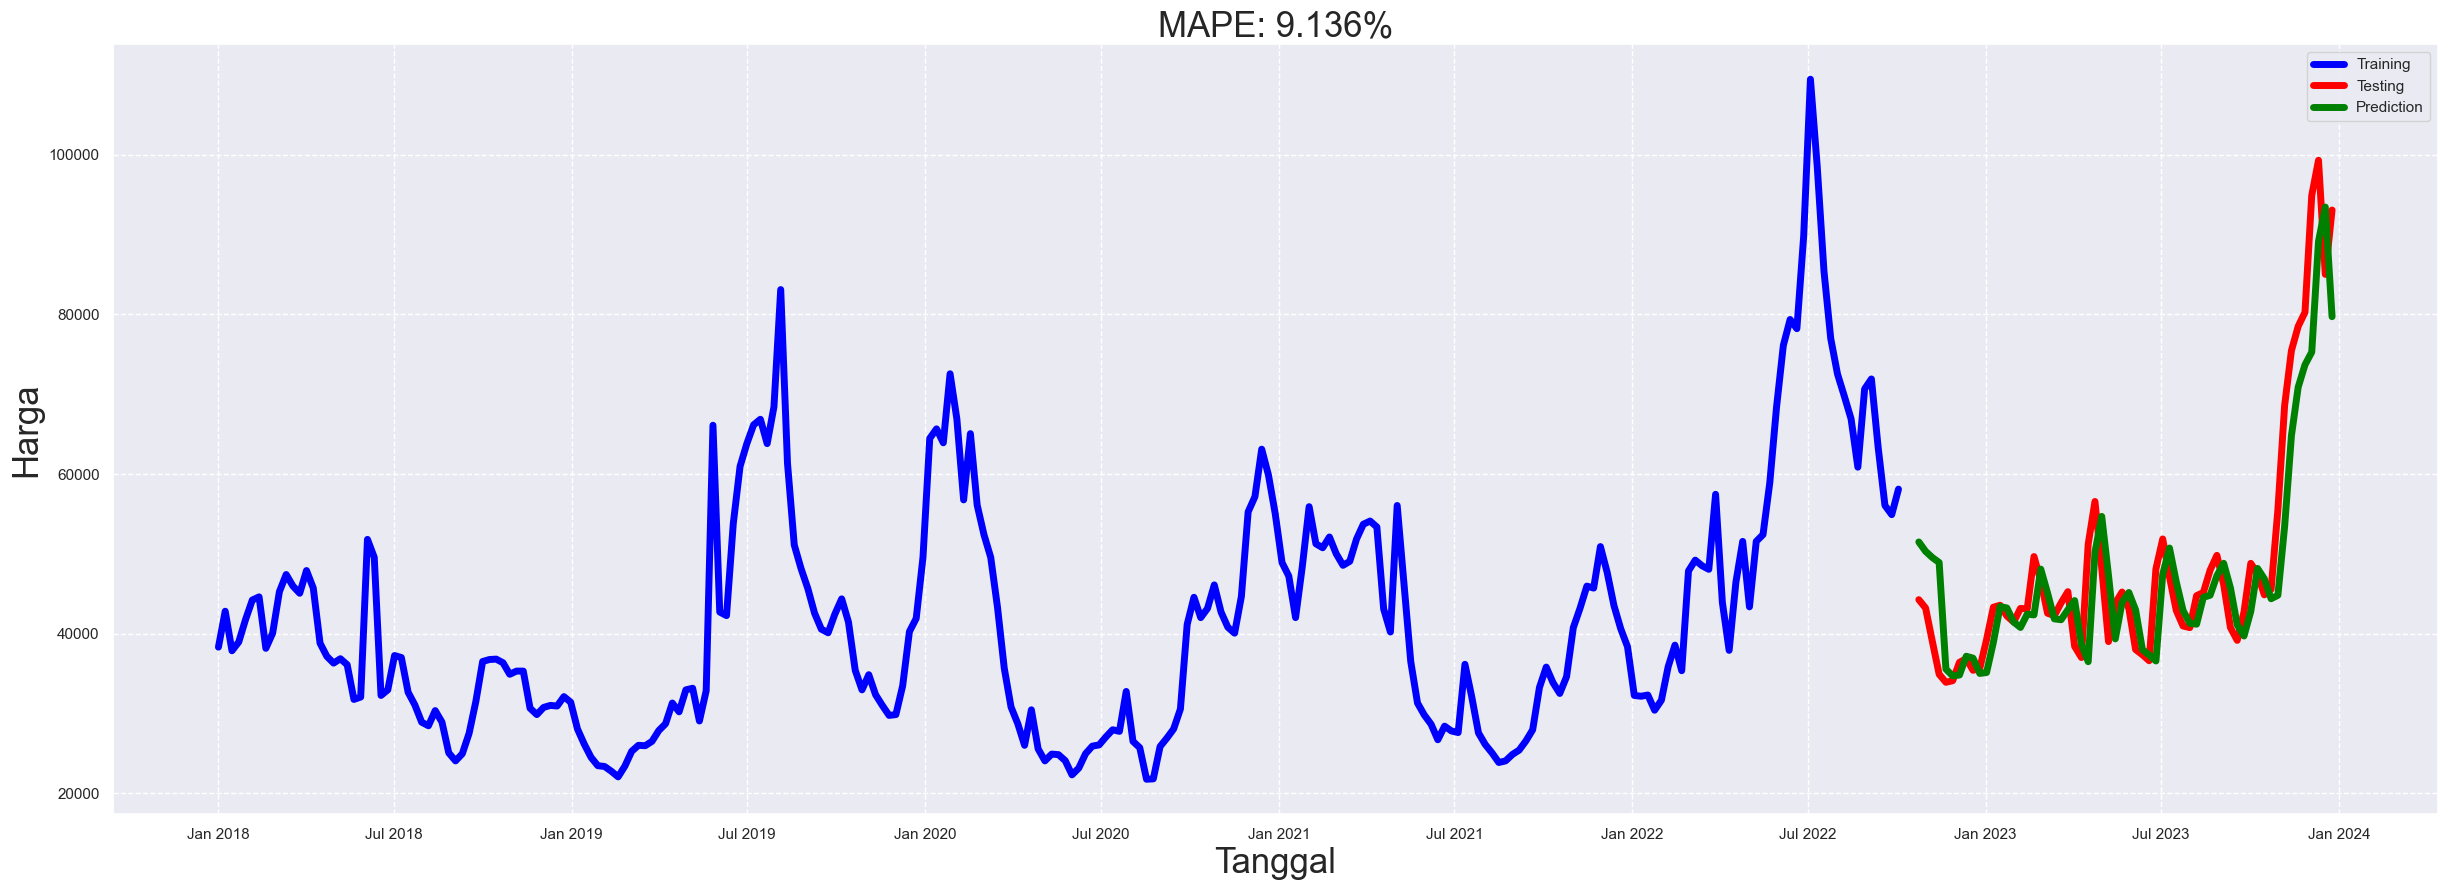

In [820]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.dates import MonthLocator, DateFormatter
mape = mean_absolute_percentage_error(testY, predictions)*100

plt.figure(figsize=(30, 10))
plt.plot(df.index[:len(trainY)], trainY, label='Training', marker='', color='blue', linestyle='-', linewidth=5)
plt.plot(df.index[-len(testY):], testY, label='Testing', marker='', color='red', linestyle='-', linewidth=5)
plt.plot(df.index[-len(predictions):], predictions, label='Prediction', marker='', color='green', linestyle='-', linewidth=5)
plt.title(f'MAPE: {mape:.3f}%', fontsize=25)
plt.xlabel('Tanggal', fontsize=25)
plt.ylabel('Harga', fontsize=25)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()

locator = MonthLocator(bymonth=[1, 7])
formatter = DateFormatter('%b %Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)
plt.show()


In [821]:
#import pickle

#Save the model to a pickle file
#with open('modelfix.pkl', 'wb') as f:
    #pickle.dump(model, f)